In [33]:
from keras.layers import Input,Dense
from keras.models import Model,Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

In [35]:
data = pd.read_csv("../data/creditcard.csv")
data["Time"] = data["Time"].apply(lambda x: x/3600 %24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x:round(100*float(x) / len(data),2))
vc = vc.rename(columns = {"index":"Target","Class":"Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


In [6]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

In [7]:
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis=1).values
Y = df["Class"].values

In [8]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    plt.figure(figsize=(12,8))
    plt.scatter(X_t[np.where(y1 == 0),0], X_t[np.where(y1 == 0),1],
                marker='o',color='g',linewidths='1',alpha=0.8,label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1),0], X_t[np.where(y1 == 1),1],
                marker='o',color='r',linewidths='1',alpha=0.8,label='Fraud')
    plt.legend(loc='best')
    plt.savefig(name)
    plt.show()

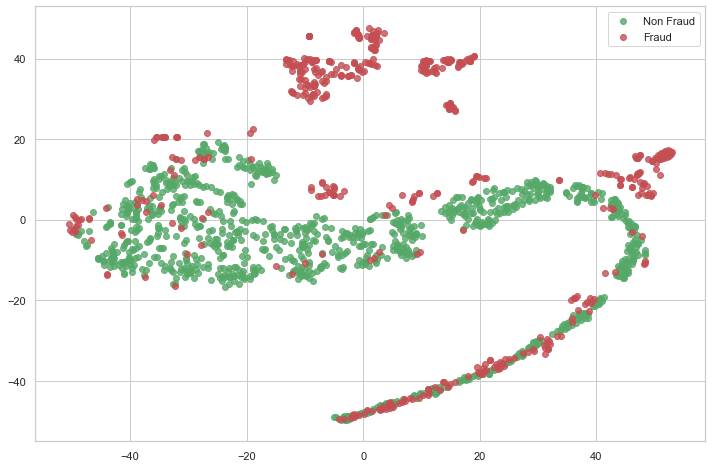

In [9]:
tsne_plot(X,Y,"original.png")

In [ ]:
input_layer = Input(shape=(X.shape[1],))

In [11]:
encoded = Dense(100, activation='tanh',activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

In [13]:
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [14]:
autoencoder = Model(input_layer,output_layer)
autoencoder.compile(optimizer="adadelta",loss="mse")

In [15]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [16]:
autoencoder.fit(x_norm[0:2000],x_norm[0:2000],
                batch_size=256, epochs=10,
                shuffle = True, validation_split = 0.20)

Instructions for updating:
Use tf.cast instead.
Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 2s 1ms/step - loss: 0.7219 - val_loss: 0.4842
Epoch 2/10
1600/1600 [==============================] - 0s 28us/step - loss: 0.4609 - val_loss: 0.3261
Epoch 3/10
1600/1600 [==============================] - 0s 26us/step - loss: 0.3052 - val_loss: 0.2209
Epoch 4/10
1600/1600 [==============================] - 0s 31us/step - loss: 0.1992 - val_loss: 0.1235
Epoch 5/10
1600/1600 [==============================] - 0s 29us/step - loss: 0.1295 - val_loss: 0.1264
Epoch 6/10
1600/1600 [==============================] - 0s 30us/step - loss: 0.1312 - val_loss: 0.0888
Epoch 7/10
1600/1600 [==============================] - 0s 26us/step - loss: 0.0991 - val_loss: 0.0966
Epoch 8/10
1600/1600 [==============================] - 0s 29us/step - loss: 0.1122 - val_loss: 0.0792
Epoch 9/10
1600/1600 [==============================] - 0s 35us/step - loss: 0.085

In [17]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [19]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

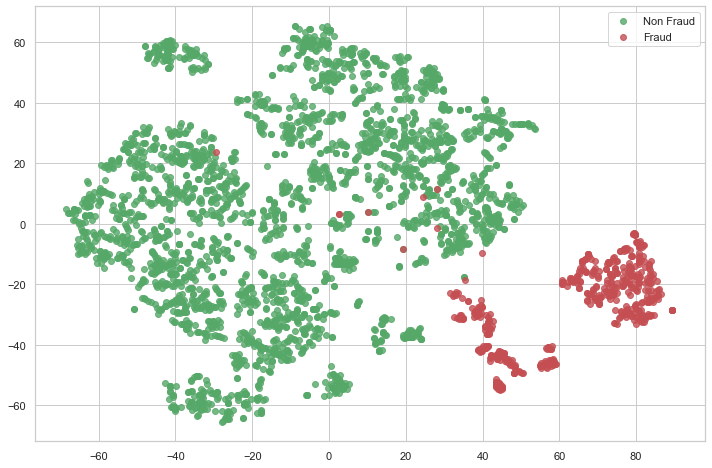

In [20]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis=0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n,y_f)
tsne_plot(rep_x,rep_y,"latent_representation.png")

In [22]:
train_x, val_x, train_y, val_y = train_test_split(rep_x,rep_y,test_size=0.25)
clf = LogisticRegression(solver='lbfgs').fit(train_x,train_y)
pred_y = clf.predict(val_x)

print("\nClassification Report: ")
print(classification_report(val_y,pred_y))

print("\nAccuracy Score: ",accuracy_score(val_y,pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       753
         1.0       1.00      0.82      0.90       120

    accuracy                           0.98       873
   macro avg       0.99      0.91      0.95       873
weighted avg       0.98      0.98      0.97       873


Accuracy Score:  0.9759450171821306


In [31]:
norm_hid_rep.shape

(3000, 50)

In [32]:
fraud_hid_rep.shape

(492, 50)